In [3]:
import dask
import dask.distributed

In [4]:
#dask.config.set({'distributed.worker.memory.target': 0.4})
#dask.config.set({'distributed.worker.memory.pause': 0.5})

In [5]:
dask.config.config["distributed"]["worker"]["memory"]

{'target': 0.4, 'spill': 0.7, 'pause': 0.5, 'terminate': 0.95}

In [6]:
import os
os.environ['RUCIO_ACCOUNT']  = 'nihartma'
os.environ['RUCIO_HOME'] = '/srv/conda/envs/notebook'

In [7]:
from ipywidgets import FileUpload
upload = FileUpload()
display(upload)

FileUpload(value={}, description='Upload')

In [8]:
x509_data = upload.data[-1]
x509_proxy_path = "/tmp/x509"
if os.path.exists(x509_proxy_path):
    os.chmod(x509_proxy_path, 0o600)
with open(x509_proxy_path, "wb") as f:
    f.write(x509_data)
os.chmod(x509_proxy_path, 0o400)
os.environ['X509_USER_PROXY'] = x509_proxy_path

In [9]:
import physlite_experiments
from physlite_experiments.physlite_events import physlite_events
from physlite_experiments.analysis_example import get_obj_sel
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import rucio.client
from tqdm.auto import tqdm
import requests
import io

first get the child dids and then run `list_replicas` in parallel

In [10]:
rucio_client = rucio.client.Client()

In [11]:
did_content = list(rucio_client.list_content("data17_13TeV", "data17_13TeV.periodK.physics_Main.PhysCont.DAOD_PHYSLITE.grp17_v01_p4309"))

In [12]:
did_content[0]

{'scope': 'data17_13TeV',
 'name': 'data17_13TeV.00338183.physics_Main.deriv.DAOD_PHYSLITE.r10258_p3399_p4309_tid22958105_00',
 'type': 'DATASET',
 'bytes': None,
 'adler32': None,
 'md5': None}

In [13]:
from concurrent.futures import ThreadPoolExecutor

In [14]:
executor = ThreadPoolExecutor(max_workers=10)

In [15]:
def list_replicas(did_dict, limit=None, signature_lifetime=7200):
    rucio_client = rucio.client.Client()
    replicas = rucio_client.list_replicas(
        [{"scope": did_dict["scope"], "name": did_dict["name"]}],
        rse_expression="GOOGLE_EU",
        signature_lifetime=signature_lifetime,
    )
    urls = []
    sizes = []
    _iter = tqdm(replicas, desc=did_dict["name"])
    if limit is None:
        _iter = enumerate(_iter)
    else:
        _iter = zip(range(limit), _iter)
    for i, replica in _iter:
        try:
            urls.append(list(replica["pfns"].keys())[0])
            sizes.append(replica["bytes"])
        except IndexError:
            print("no replica for", replica["name"])
    return urls, sizes

example to cross check signature expiry:
```python
_urls = list_replicas(did_content[0], limit=10)

import datetime
import pytz

(
    pytz.utc.localize(datetime.datetime.fromtimestamp(int(_urls[0].split("&")[1].split("=")[1])))
    .astimezone(pytz.timezone("Europe/Berlin"))
).strftime("%Y-%m-%d %H:%M:%S %Z%z")
```

In [ ]:
urls_list = executor.map(list_replicas, did_content)

The analysis will be run on data directly downloaded into memory:

In [37]:
def download(url):
    return requests.get(url).content

In [38]:
data = download(urls[0])

In [39]:
rootfile = uproot.open(io.BytesIO(data))

In [40]:
tree = rootfile["CollectionTree"]

In [41]:
from physlite_experiments.utils import subdivide
import math

In [42]:
events = physlite_events(tree)

Skipping EventInfoAuxDyn.streamTagRobs
Skipping EventInfoAuxDyn.streamTagDets
Can't interpret PrimaryVerticesAuxDyn.neutralParticleLinks
Skipping AnalysisHLT_tau35_medium1_tracktwo_tau25_medium1_tracktwo_03dR30_L1DR-TAU20ITAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_tau35_medium1_tracktwo_tau25_medium1_tracktwo_L1DR-TAU20ITAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_tau35_medium1_tracktwo_tau25_medium1_tracktwo_tautsf_L1DR-TAU20ITAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_mu14_ivarloose_tau25_medium1_tracktwo_L1DR-MU10TAU12I_TAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_tau80_medium1_tracktwo_L1TAU60_tau35_medium1_tracktwo_L1TAU12IM_L1TAU60_DR-TAU20ITAU12IAuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_e17_lhmedium_nod0_ivarloose_tau25_medium1_tracktwo_L1DR-EM15TAU12I-J25AuxDyn.TrigMatchedObjects


In [43]:
events.Electrons.pt

<Array [[], [], [], ... 3.45e+04], [], []] type='44235 * var * float32'>

This is the actual analysis part, it runs some object selections on Electrons, Muons, Jets with overlap removal and adds `baseline`, `signal` and `passOR` fields.

In [44]:
events_decorated = get_obj_sel(events)

/srv/conda/envs/notebook/lib/python3.8/site-packages/awkward/_connect/_numpy.py:160: RuntimeWarning: divide by zero encountered in true_divide
  result = getattr(ufunc, method)(


In this version i forgot to add the muon mass, so let's add it to do some dilepton invariant mass plots:

In [45]:
events_decorated["Muons", "m"] = 105.6583715

In [46]:
leptons = ak.concatenate([events_decorated.Electrons, events_decorated.Muons], axis=1)
leptons = ak.with_parameter(leptons, "__record__", "xAODParticle")

In [47]:
l1, l2 = ak.unzip(ak.combinations(leptons.mask[leptons.signal & leptons.passOR], 2))

In [48]:
m = (l1 + l2).mass
m = ak.flatten(m, axis=None)
m = ak.to_numpy(m)

Dilepton invariant mass for signal leptons - the Upsilon and the Z peak are visible already from one file:

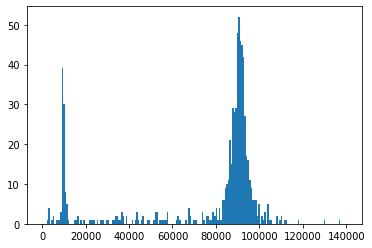

In [49]:
plt.hist(m, bins=200, range=(0, 140000));

let's wrap it into a single function that takes the binary data and outputs an arrow buffer for the lepton 4-momenta and the object selection flags:

In [50]:
import gc

In [51]:
def get_leptons(data, max_chunksize=50000):
    with uproot.open(io.BytesIO(data)) as f:
        tree = f["CollectionTree"]
        entry_start = 0
        leptons = []
        n = tree.num_entries
        for chunksize in subdivide(n, math.ceil(n / max_chunksize)):
            entry_stop = entry_start + chunksize
            events = physlite_events(tree, entry_start=entry_start, entry_stop=entry_stop)
            entry_start = entry_stop
            events_decorated = get_obj_sel(events)
            events_decorated["Muons", "m"] = 105.6583715
            leptons.append(
                ak.concatenate([events_decorated.Electrons, events_decorated.Muons], axis=1)
            )
        leptons = ak.concatenate(leptons)
        leptons = ak.to_arrow(leptons[["pt", "eta", "phi", "m", "passOR", "baseline", "signal"]])
    gc.collect()
    return leptons

In [ ]:
%%time
l = ak.from_arrow(get_leptons(data, max_chunksize=20000))

In [53]:
len(l)

44235

And then run it on dask on all files:

In [54]:
from dask import delayed
import dask

In [55]:
# local cluster:
#from dask.distributed import Client

#client = Client(n_workers=8, threads_per_worker=1)
#client

In [56]:
#client.shutdown()

In [57]:
# enter proxy/8787 in field on the left

In [58]:
#client.restart()

In [60]:
# gateway cluster
from dask_gateway import GatewayCluster
cluster = GatewayCluster(
    worker_cores=2,
    worker_memory=8,
    image="eu.gcr.io/gke-dev-311213/dask-gateway-physlite:20210526"
)

In [61]:
cluster

In [62]:
#cluster.scale(100)
cluster.scale(50)

In [109]:
#cluster.shutdown()

In [64]:
client = cluster.get_client()

In [65]:
#client.restart()

build the task graph:

In [66]:
delayed_leptons = []
for url in urls[::10]:
    d_data = delayed(download)(url)
    delayed_leptons.append(delayed(get_leptons)(d_data))

In [67]:
from dask.distributed import performance_report, wait, fire_and_forget

to save task graph:
```python
with performance_report(filename="dask-report-1percent.html"):
    (delayed_leptons,) = dask.persist(delayed_leptons)
    wait(delayed_leptons)
    #fire_and_forget(dask.compute(delayed_leptons))
```

In [68]:
(delayed_leptons,) = dask.persist(delayed_leptons)

In [103]:
def get_mass(leptons, selection="all"):
    leptons = ak.from_arrow(leptons)
    leptons = ak.with_parameter(leptons, "__record__", "xAODParticle")
    if selection == "all":
        l1, l2 = ak.unzip(ak.combinations(leptons, 2))
    elif selection == "signal":
        l1, l2 = ak.unzip(ak.combinations(leptons.mask[leptons.signal & leptons.passOR], 2))
    elif selection == "baseline":
        l1, l2 = ak.unzip(ak.combinations(leptons.mask[leptons.baseline & leptons.passOR], 2))
    l1, l2 = [ak.with_parameter(i, "__record__", "xAODParticle") for i in [l1, l2]]
    m = (l1 + l2).mass
    m = ak.flatten(m, axis=None)
    m = ak.to_numpy(m)
    return m

In [73]:
l = dask.compute(delayed_leptons[0])

In [74]:
delayed_leptons[2]

Delayed('get_leptons-7a34a7a6-1a4f-4a81-bde9-6c67f9765b9b')

In [75]:
_ = dask.compute(delayed(get_mass)(delayed_leptons[0]))

In [76]:
delayed_leptons[0]

Delayed('get_leptons-4bc1fd56-af9a-4eb1-a77c-e7b43f3b7cfe')

In [79]:
from dask.distributed import futures_of

In [87]:
delayed_leptons_ok = [t for t in delayed_leptons if futures_of(t)[0].status == "finished"]

In [88]:
len(delayed_leptons_ok)

2539

In [89]:
len(delayed_leptons)

2540

In [104]:
from functools import partial

In [105]:
(m_list_all,) = dask.compute([delayed(partial(get_mass, selection="all"))(i) for i in delayed_leptons_ok])

In [106]:
(m_list_baseline,) = dask.compute([delayed(partial(get_mass, selection="baseline"))(i) for i in delayed_leptons_ok])

In [101]:
GeV = 1000

<ipython-input-117-d6730309f2d1>:9: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 1e7)


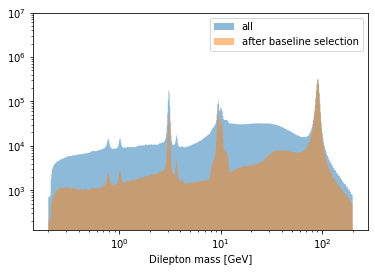

In [117]:
opts = dict(
    bins=np.geomspace(0.2, 200, 500),
    histtype="stepfilled", alpha=0.5
)
plt.hist(np.concatenate(m_list_all) / GeV, label="all", **opts);
plt.hist(np.concatenate(m_list_baseline) / GeV, label="after baseline selection", **opts);
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Dilepton mass [GeV]")
plt.legend()
plt.ylim(0, 1e7)
plt.savefig("m2l_baseline_1percent.pdf")